In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
! pip install mlxtend

In [2]:
lastfm_df_final = pd.read_csv("lastfm_processed.csv")

# FP-Growth

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

transactions = lastfm_df_final['artist_playlist'].tolist()

# encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Processed {len(df_trans)} transactions with {len(te.columns_)} unique artists.")

Processed 15000 transactions with 1004 unique artists.


In [19]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

param_grid = [
    {"min_sup": 0.01, "min_conf": 0.30},
    {"min_sup": 0.02, "min_conf": 0.30},
    {"min_sup": 0.006, "min_conf": 0.30},  
    {"min_sup": 0.003, "min_conf": 0.30},  

    {"min_sup": 0.01, "min_conf": 0.50},
    {"min_sup": 0.02, "min_conf": 0.50},
    {"min_sup": 0.006, "min_conf": 0.50},
    {"min_sup": 0.003, "min_conf": 0.50},

    {"min_sup": 0.006, "min_conf": 0.55},
    {"min_sup": 0.003, "min_conf": 0.55},
    {"min_sup": 0.003, "min_conf": 0.60},
]

results = []
models = {} # store rules 

for i, params in enumerate(param_grid):
    model_name = f"Model_{i+1}"
    print(f"Running {model_name} with {params}...")
    
    try:
        # run fp-growth
        frequent_itemsets = fpgrowth(df_trans, min_support=params['min_sup'], use_colnames=True)
        
        if frequent_itemsets.empty:
            print(f"-> no pattern found, skip")
            continue
            
        # generate rules
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=params['min_conf'])
        
        # metrics
        if not rules.empty:
            # filter for meaningful lift
            rules = rules[rules['lift'] > 1.0]
            
            n_rules = len(rules)
            avg_lift = rules['lift'].mean()
            
            # coverage: how many unique artists appear in the antecedents
            unique_inputs = set([list(x)[0] for x in rules['antecedents']])
            coverage_pct = (len(unique_inputs) / len(te.columns_)) * 100
            
            results.append({
                'Model': model_name,
                'Min_Sup': params['min_sup'],
                'Min_Conf': params['min_conf'],
                'Num_Rules': n_rules,
                'Avg_Lift': avg_lift,
                'Coverage_Pct': coverage_pct
            })
            
            models[model_name] = rules
        else:
            print(f"-> no rules generated")
            
    except Exception as e:
        print(f"Error in {model_name}: {e}")

Running Model_1 with {'min_sup': 0.01, 'min_conf': 0.3}...
Running Model_2 with {'min_sup': 0.02, 'min_conf': 0.3}...
Running Model_3 with {'min_sup': 0.006, 'min_conf': 0.3}...
Running Model_4 with {'min_sup': 0.003, 'min_conf': 0.3}...
Running Model_5 with {'min_sup': 0.01, 'min_conf': 0.5}...
Running Model_6 with {'min_sup': 0.02, 'min_conf': 0.5}...
Running Model_7 with {'min_sup': 0.006, 'min_conf': 0.5}...
Running Model_8 with {'min_sup': 0.003, 'min_conf': 0.5}...
Running Model_9 with {'min_sup': 0.006, 'min_conf': 0.55}...
Running Model_10 with {'min_sup': 0.003, 'min_conf': 0.55}...
Running Model_11 with {'min_sup': 0.003, 'min_conf': 0.6}...


C:\Users\Admin\AppData\Local\Temp\ipykernel_25248\1292772484.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Num_Rules', ax=axes[0], palette='Blues_d')
C:\Users\Admin\AppData\Local\Temp\ipykernel_25248\1292772484.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Avg_Lift', ax=axes[1], palette='Greens_d')
C:\Users\Admin\AppData\Local\Temp\ipykernel_25248\1292772484.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Coverage_Pct', ax=axes[2], 

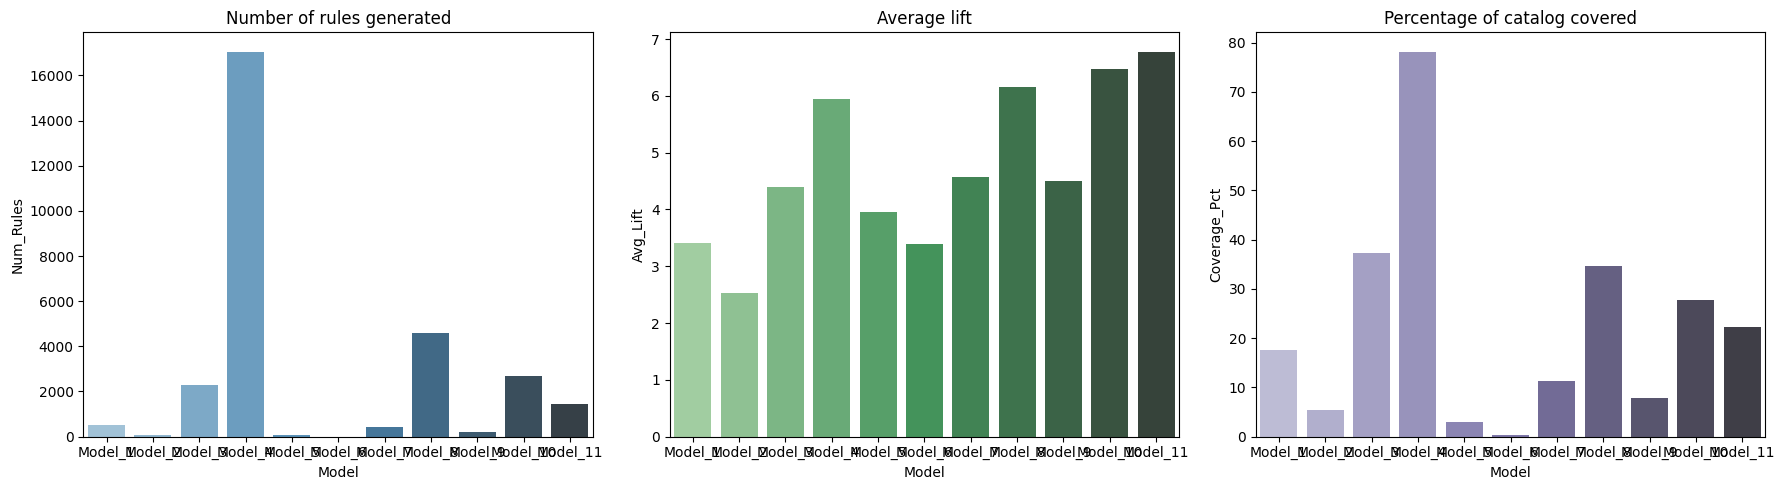

In [47]:
import seaborn as sns

results_df = pd.DataFrame(results)

if not results_df.empty:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # number of Rules (quantity)
    sns.barplot(data=results_df, x='Model', y='Num_Rules', ax=axes[0], palette='Blues_d')
    axes[0].set_title("Number of rules generated")
    
    # average lift (quality)
    sns.barplot(data=results_df, x='Model', y='Avg_Lift', ax=axes[1], palette='Greens_d')
    axes[1].set_title("Average lift")
    
    # coverage (utility)
    sns.barplot(data=results_df, x='Model', y='Coverage_Pct', ax=axes[2], palette='Purples_d')
    axes[2].set_title("Percentage of catalog covered")
    
    plt.tight_layout()
    plt.show()

else:
    print("No rules found in any config -> lower min_sup")
    exit()

In [35]:
results_df

,Model,Min_Sup,Min_Conf,Num_Rules,Avg_Lift,Coverage_Pct
0,Model_1,0.010,0.30,498,3.410803,17.629482
1,Model_2,0.020,0.30,90,2.536445,5.378486
2,Model_3,0.006,0.30,2281,4.393722,37.250996
3,Model_4,0.003,0.30,17059,5.947561,78.187251
4,Model_5,0.010,0.50,50,3.962917,2.988048
5,Model_6,0.020,0.50,3,3.386076,0.298805
6,Model_7,0.006,0.50,406,4.566092,11.254980
7,Model_8,0.003,0.50,4584,6.161467,34.661355
8,Model_9,0.006,0.55,212,4.495287,7.768924
9,Model_10,0.003,0.55,2681,6.471283,27.788845


In [ ]:
best_model_name = 'Model_8'
models[best_model_name].to_pickle('fpgrowth_rules.pkl')

rules_df = pd.read_pickle('fpgrowth_rules.pkl')
rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"(red hot chili peppers, the killers)",(coldplay),0.021333,0.158533,0.010867,0.509375,3.213047,1.0,0.007485,1.715091,0.703783,0.064300,0.416941,0.288960
1,"(radiohead, red hot chili peppers, the killers)",(coldplay),0.006933,0.158533,0.004267,0.615385,3.881736,1.0,0.003168,2.187813,0.747566,0.026468,0.542923,0.321149
2,"(radiohead, red hot chili peppers, the killers)",(muse),0.006933,0.114067,0.003733,0.538462,4.720586,1.0,0.002942,1.919522,0.793665,0.031836,0.479037,0.285595
3,"(red hot chili peppers, the killers, muse)",(coldplay),0.008333,0.158533,0.004733,0.568000,3.582843,1.0,0.003412,1.947840,0.726950,0.029194,0.486611,0.298929
4,"(red hot chili peppers, the killers, the beatles)",(coldplay),0.006800,0.158533,0.004000,0.588235,3.710483,1.0,0.002922,2.043562,0.735495,0.024793,0.510658,0.306733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,(serj tankian),(system of a down),0.016133,0.091000,0.008933,0.553719,6.084824,1.0,0.007465,2.036833,0.849360,0.090971,0.509042,0.325944
4580,"(serj tankian, metallica)",(system of a down),0.005267,0.091000,0.003600,0.683544,7.511476,1.0,0.003121,2.872440,0.871460,0.038849,0.651864,0.361552
4581,(the breeders),(pixies),0.006933,0.049800,0.003467,0.500000,10.040161,1.0,0.003121,1.900400,0.906686,0.065081,0.473795,0.284806
4582,(black label society),(metallica),0.009733,0.111333,0.004933,0.506849,4.552539,1.0,0.003850,1.802019,0.788012,0.042480,0.445067,0.275580


In [ ]:
def recommend_artists_fp(df, artist_name, k=10, metric='lift'):
    # find rules where the input artist is present in the antecedents
    mask = df['antecedents'].apply(lambda x: artist_name in x)
    relevant_rules = df[mask].copy()

    if relevant_rules.empty:
        return f"No rules found for artist: {artist_name}"

    # sort
    sorted_rules = relevant_rules.sort_values(by=metric, ascending=False)

    # get the consequent artists
    recommendations = []
    seen = set()

    for _, row in sorted_rules.iterrows():
        for artist in row['consequents']:
            if artist not in seen and artist != artist_name:
                recommendations.append(artist)
                seen.add(artist)
                
            if len(recommendations) >= k:
                break
        if len(recommendations) >= k:
            break
            
    return recommendations

recs = recommend_artists_fp(rules, 'red hot chili peppers', k=10, metric='lift')

print(f"Top 10 recommendations: {recs}")

Top 10 recommendations: ['foo fighters', 'system of a down', 'the killers', 'metallica', 'muse', 'coldplay', 'radiohead']


In [ ]:
unique_artists = set()
for itemset in rules['antecedents']: # specific to your 'rules' dataframe
    unique_artists.update(itemset)

print(f"Starting recommendation generation for {len(unique_artists)} artists found in rules...")

results_list = []

# loop through valid artists
for artist in unique_artists:
    recs = recommend_artists_fp(rules, artist, k=10, metric='lift')

    if isinstance(recs, list) and recs:
        rec_string = "|".join(recs)
        results_list.append({
            'Artist': artist,
            'Recommendations': rec_string
        })

final_rec_db = pd.DataFrame(results_list)

# sort alphabetically
final_rec_db = final_rec_db.sort_values(by='Artist')
final_rec_db.to_csv('artist_recommendations_fp_growth.csv', index=False)

Starting recommendation generation for 280 artists found in rules...


# Collaborative filtering

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

df_exploded = lastfm_df_final.explode('artist_playlist')

# drop empty rows if any
df_exploded = df_exploded.dropna(subset=['artist_playlist'])

# count how many users listen to each artist
artist_counts = df_exploded['artist_playlist'].value_counts()

# keep only artists with at least 50 listeners
min_listeners = 50
valid_artists = artist_counts[artist_counts >= min_listeners].index
df_filtered = df_exploded[df_exploded['artist_playlist'].isin(valid_artists)]


In [65]:
# get all unique artists and users
unique_artists = df_filtered['artist_playlist'].unique()
unique_users = df_filtered['user'].unique()

# mapping
artist_to_idx = {artist: i for i, artist in enumerate(unique_artists)}
idx_to_artist = {i: artist for i, artist in enumerate(unique_artists)}
user_to_idx = {user: i for i, user in enumerate(unique_users)}

df_filtered['artist_id'] = df_filtered['artist_playlist'].map(artist_to_idx)
df_filtered['user_id'] = df_filtered['user'].map(user_to_idx)

In [ ]:
# create a matrix: rows = artists, cols = users, value = 1 
num_artists = len(unique_artists)
num_users = len(unique_users)

# csr_matrix((data, (row_ind, col_ind)), shape)
artist_user_matrix = csr_matrix(
    (np.ones(len(df_exploded)), (df_filtered['artist_id'], df_filtered['user_id'])),
    shape=(num_artists, num_users)
)

print(f"Matrix shape: {artist_user_matrix.shape} (Artists x Users)")

Matrix shape: (1004, 15000) (Artists x Users)


In [68]:
from sklearn.feature_extraction.text import TfidfTransformer

# lower weights of popular artists
tfidf = TfidfTransformer()
artist_user_matrix_tfidf = tfidf.fit_transform(artist_user_matrix)

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

model_knn.fit(artist_user_matrix_tfidf)

print("Done training")

Done training


In [85]:
def get_recommendations_cf(artist_name, k=10):
    if artist_name not in artist_to_idx:
        return [f"Artist '{artist_name}' not found."]
    
    art_id = artist_to_idx[artist_name]
    artist_vec = artist_user_matrix[art_id]
    
    # find neighbors
    distances, indices = model_knn.kneighbors(artist_vec, n_neighbors=k+1)
    
    recommendations = []
    names = []
    raw_indices = indices.flatten()
    raw_distances = distances.flatten()
    
    for i in range(len(raw_indices)):
        idx = raw_indices[i]
        dist = raw_distances[i]
        
        name = idx_to_artist[idx]

        if name != artist_name:
            similarity = 1 - dist
            recommendations.append((name, round(similarity, 4)))
            names.append(name)
            
    return recommendations, names

# test
results, names = get_recommendations_cf('death', k=10)
for artist, score in results:
    print(f"{artist}: {score}")

carcass: 0.3394
testament: 0.305
morbid angel: 0.2954
kreator: 0.2765
slayer: 0.2759
nile: 0.2744
cannibal corpse: 0.2735
sodom: 0.2326
megadeth: 0.2317
opeth: 0.2308


In [79]:
unique_artists = df_filtered['artist_playlist'].unique()
unique_artists.shape

(1004,)

In [ ]:
print(f"Starting recommendation generation for {len(unique_artists)} artists found in rules...")

results_list_cf = []
names_list_cf = []

for artist in unique_artists:
    
    recs, names = get_recommendations_cf(artist, k=10)
    if recs:
        formatted_recs = [f"{name}: {score}" for name, score in recs]
        rec_string = "|".join(formatted_recs)
        results_list_cf.append({
            'Artist': artist,
            'Recommendations': rec_string
        })
    if names:
        name_string = "|".join(names)
        names_list_cf.append({
            'Artist': artist,
            'Recommendations': name_string
        })

final_rec_cf = pd.DataFrame(results_list_cf)
final_rec_cf = final_rec_cf.sort_values(by='Artist')
output_file = 'artist_recommendations_cf.csv'
final_rec_cf.to_csv(output_file, index=False)

final_rec_cf_filtered = pd.DataFrame(names_list_cf)
final_rec_cf_filtered = final_rec_cf_filtered.sort_values(by='Artist')
output_file_ft = 'artist_recommendations_cf_filtered.csv'
final_rec_cf_filtered.to_csv(output_file_ft, index=False)


Starting recommendation generation for 1004 artists found in rules...


# Comparison between two recommendation engines

In [ ]:
df_fp = pd.read_csv('artist_recommendations_fp_growth.csv') 
df_cf = pd.read_csv('artist_recommendations_cf_filtered.csv') 

# merge on 'Artist'
df_merged = pd.merge(df_fp, df_cf, on='Artist', suffixes=('_fp', '_cf'))

# parse strings
def get_names_set(rec_string):
    if pd.isna(rec_string) or rec_string == "":
        return set()
    
    items = rec_string.split('|')
    
    cleaned_names = set()
    for item in items:
        name_only = item.split(':')[0]
        cleaned_names.add(name_only.strip().lower())
        
    return cleaned_names

# calculate overlap
overlap_scores = []

for index, row in df_merged.iterrows():
    set_fp = get_names_set(row['Recommendations_fp'])
    set_cf = get_names_set(row['Recommendations_cf'])

    intersection = set_fp.intersection(set_cf)
    
    # calculate percentage based on the size of the lists (k=10)
    denominator = max(len(set_fp), len(set_cf), 1) 
    overlap_pct = (len(intersection) / denominator) * 100
    
    overlap_scores.append(overlap_pct)

df_merged['Overlap_Percentage'] = overlap_scores
average_overlap = df_merged['Overlap_Percentage'].mean()
print(f"Average overlap between models: {average_overlap:.2f}%")

# df_merged[['Artist', 'Overlap_Percentage', 'Recommendations_fp', 'Recommendations_cf']].to_csv('model_comparison.csv', index=False)

Average overlap between models: 18.36%
